In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(1)

In [3]:
import sys, os
sys.path.append(os.path.abspath("../hier-topic-models/"))
from load_data import load_data, load_vocab

In [4]:
# data = load_data("/Users/aleverentz/Downloads/ap/ap.dat")
# vocab = load_vocab("/Users/aleverentz/Downloads/ap/vocab.txt")

In [5]:
from learn_topics import Analysis, Params

In [6]:
%%time

loss = "L2"
K = 50

a = Analysis(params = Params(
    #infile = data.transpose(),
    #vocab_file = vocab,
    infile = "M_nips.full_docs.mat.trunc.mat",
    vocab_file = "vocab.nips.txt.trunc",
    #infile = "/Users/aleverentz/ucsd-classes/research/hier-topic-models/data/abstracts.mat.trunc.mat",
    #vocab_file = "/Users/aleverentz/ucsd-classes/research/hier-topic-models/data/abstracts_vocab.txt.trunc",
    outfile = None,
    #outfile = "demo_{}_out.nips.{}".format(loss, K),
    loss = loss,
    K = K,
    seed = 100,
    eps = 1e-6,
    new_dim = 1000,
    max_threads = 8,
    anchor_thresh = 100,
    top_words = 10,
))
a.run()

Input matrix shape: (2940, 1500)
identifying candidate anchors
1735 candidates
Sum of entries in Q is  1.0
Multiplying Q took  1.168727159500122 seconds
Q sum is 1.0
done reading documents
anchors are:
0 neuroscience
1 part
2 iii
3 cognitive
4 paul
5 science
6 architecture
7 theory
8 visual
9 processing
10 policy
11 head
12 speaker
13 spike
14 character
15 motion
16 speech
17 face
18 chip
19 classifier
20 control
21 boolean
22 teacher
23 missing
24 sound
25 controller
26 view
27 kernel
28 word
29 orientation
30 expert
31 batch
32 motor
33 clustering
34 winner
35 hopfield
36 channel
37 convex
38 member
39 rules
40 letter
41 user
42 carlo
43 penalty
44 robot
45 contour
46 operator
47 synapses
48 loss
49 rbf
begin threaded recovery with 8 processors
0	75	0.23305823507318857
1000	78	0.1080726446585983
2000	72	0.18262382419260068
done recovering
neuroscience : neuroscience application implementation navigation planning algorithm hierarchy matching circuit zemel 
part : part algorithm signal

In [7]:
for t in a.all_topwords:
    print("Topic {}: Anchor word '{}'\n  {}".format(t.topic_index, t.anchor_word, ", ".join(t.top_words)))

Topic 0: Anchor word 'neuroscience'
  neuroscience, application, implementation, navigation, planning, algorithm, hierarchy, matching, circuit, zemel
Topic 1: Anchor word 'part'
  part, algorithm, signal, application, problem, implementation, memory, parallel, information, processor
Topic 2: Anchor word 'iii'
  iii, field, distribution, probability, bound, approximation, examples, equation, statistical, order
Topic 3: Anchor word 'cognitive'
  cognitive, connectionist, action, representation, level, structure, category, constraint, grammar, language
Topic 4: Anchor word 'paul'
  david, michael, john, richard, peter, index, author, thomas, paul, eric
Topic 5: Anchor word 'science'
  science, representation, level, structure, category, subject, constraint, goal, set, environment
Topic 6: Anchor word 'architecture'
  architecture, algorithm, unit, problem, step, weight, pattern, gradient, node, vector
Topic 7: Anchor word 'theory'
  theory, approximation, case, evidence, ill, peak, region

In [8]:
%%time
R = a.R

CPU times: user 117 ms, sys: 14.5 ms, total: 132 ms
Wall time: 49 ms


In [9]:
R.shape

(50, 50)

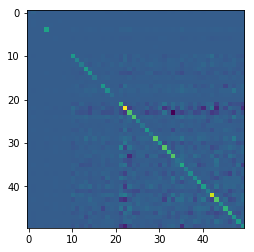

In [10]:
plt.figure()
plt.imshow(R);

### Hierarchical clustering of anchor words

In [11]:
import scipy.cluster.hierarchy as sch

In [12]:
metric_L1 = lambda x,y: np.sum(np.abs(x - y))
metric_L2sq = lambda x,y: np.sum((x - y)**2)
metric_L2 = lambda x,y: np.sqrt(np.sum((x - y)**2))

In [13]:
linkage = sch.linkage(a.A.transpose(), method="complete", metric=metric_L1)

In [14]:
anchor_word_labels = ["{} ({})".format(a.vocab[w], w) for w in a.anchors]

In [15]:
even_plot_spacing = False
if even_plot_spacing:
    linkage[:, 2] = np.arange(1, linkage.shape[0] + 1)

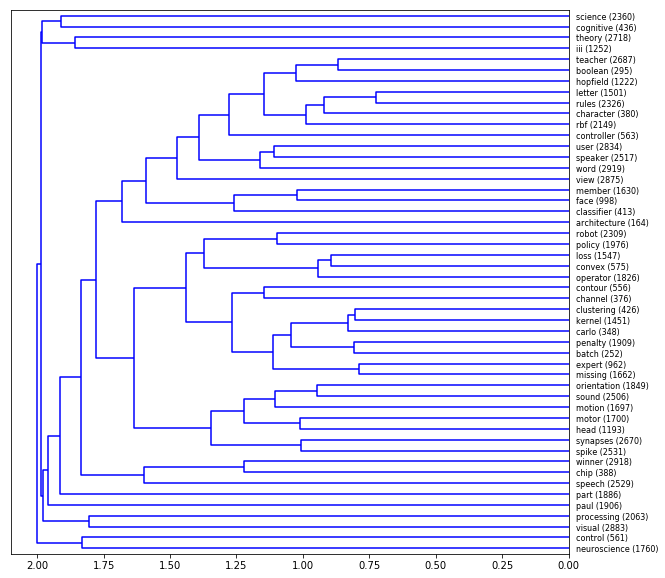

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
sch.dendrogram(linkage, orientation='left', labels=anchor_word_labels, color_threshold=0, ax=ax);

In [17]:
topic_likelihoods = np.asarray(a.topic_likelihoods).squeeze()

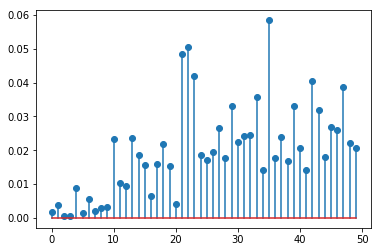

In [18]:
plt.stem(topic_likelihoods);

In [19]:
ii = np.argmax(topic_likelihoods)
a.all_topwords[ii]

TopWordsSummary(topic_index=35, anchor_word_index=1222, anchor_word='hopfield', top_word_indices=array([1749, 1751, 1754, 2674, 2054,  816, 1971, 1905,  894, 1101]), top_words=['network', 'neural', 'neuron', 'system', 'problem', 'dynamic', 'point', 'pattern', 'equation', 'function'])

In [20]:
# Augment the topic matrix with columns that represent combined clusters
vocab_size = a.A.shape[0]
num_orig_topics = a.A.shape[1]
num_meta_topics = linkage.shape[0]
A_augmented = np.zeros((vocab_size, num_orig_topics + num_meta_topics))
topic_likelihoods_augmented = np.zeros((num_orig_topics + num_meta_topics,))

A_augmented[:, :num_orig_topics] = a.A
topic_likelihoods_augmented[:num_orig_topics] = topic_likelihoods

for cluster_index, t in enumerate(linkage):
    i, j = int(t[0]), int(t[1])
    alpha = topic_likelihoods_augmented[i]
    beta  = topic_likelihoods_augmented[j]
    p = alpha + beta
    p1, p2 = alpha / p, beta / p
    topic_likelihoods_augmented[cluster_index + num_orig_topics] = p
    A_augmented[:, cluster_index + num_orig_topics] = \
        p1 * A_augmented[:, i] + p2 * A_augmented[:, j]

In [21]:
def top_words(A, num_top_words, vocab = None):
    # Get top words for augmented topic matrix
    A = np.asarray(A)
    target_shape = (num_top_words, A.shape[1])
    probs = np.zeros(target_shape)
    word_indices = np.zeros(target_shape, dtype='int')
    words = np.empty(target_shape, dtype='object')
    for k in range(A.shape[1]):
        # First, use argpartition to find top word indices (unsorted)
        top_indices_unsorted = np.argpartition(A[:, k], -num_top_words)[-num_top_words:]
        top_probabilities_unsorted = A[top_indices_unsorted, k]
        # Then, sort within the top num_top_words
        meta_sort_indices = np.argsort(-top_probabilities_unsorted)
        top_indices_sorted = top_indices_unsorted[meta_sort_indices]
        top_probabilities_sorted = top_probabilities_unsorted[meta_sort_indices]
        word_indices[:, k] = top_indices_sorted
        probs[:, k] = top_probabilities_sorted
        if vocab is not None:
            words[:, k] = [vocab[w] for w in top_indices_sorted]
    if vocab is None:
        return probs, word_indices
    else:
        return probs, word_indices, words

In [22]:
probs, indices, words = top_words(A_augmented, num_top_words=10, vocab=a.vocab)

In [23]:
import pandas as pd

In [24]:
pd.DataFrame(words)

,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
0,neuroscience,part,iii,cognitive,david,science,architecture,theory,visual,processing,...,control,network,theory,science,network,network,network,theory,network,network
1,application,algorithm,field,connectionist,michael,representation,algorithm,approximation,signal,signal,...,neuroscience,function,iii,cognitive,function,function,function,science,function,function
2,implementation,signal,distribution,action,john,level,unit,case,image,object,...,application,input,approximation,representation,input,input,input,cognitive,input,input
3,navigation,application,probability,representation,richard,structure,problem,evidence,level,information,...,implementation,neural,distribution,level,neural,neural,neural,iii,neural,neural
4,planning,problem,bound,level,peter,category,step,ill,object,eye,...,planning,algorithm,probability,structure,algorithm,algorithm,algorithm,approximation,algorithm,algorithm
5,algorithm,implementation,approximation,structure,index,subject,weight,peak,spatial,position,...,navigation,set,case,category,set,set,set,structure,set,set
6,hierarchy,memory,examples,category,author,constraint,pattern,region,feature,target,...,algorithm,system,evidence,constraint,system,system,system,distribution,system,system
7,matching,parallel,equation,constraint,thomas,goal,gradient,effect,features,attention,...,optimal,data,ill,subject,data,data,data,probability,data,data
8,circuit,information,statistical,grammar,paul,set,node,probability,activity,feature,...,dynamic,training,peak,grammar,training,training,training,case,training,training
9,zemel,processor,order,language,eric,environment,vector,term,images,layer,...,trajectory,unit,term,environment,unit,unit,unit,set,unit,unit


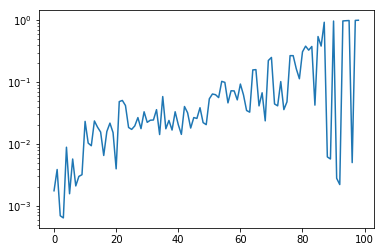

In [25]:
fig, ax = plt.subplots()
ax.semilogy(topic_likelihoods_augmented);